In [1]:
import numpy as np



import tensorflow as tf


from tensorflow import keras
from tensorflow.keras import layers

import scipy.interpolate as interp
from scipy.interpolate import interp1d

tf.config.set_visible_devices([], 'GPU')


In [2]:
import camb
from camb import model, initialpower
from scipy.interpolate import interp1d
import scipy as sp
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import emcee




### Compare Model_As_fixed vs Model_As_Flex

#### Model As_fixed

In [3]:

def R_mass(Mass, pars):
    Om0_in = pars.omegam
    # Chisari et al arXiv:1812.05995
    Radius = (Mass / (1.162e12 * Om0_in))**(1. / 3.) # [Mpc/h]
    return Radius


def splint_nt(xa, ya, y2a, n, x):

    for i in range(n):
        if(xa[i] > x):
            klo = i - 1
            khi = i
            break;
        #else:
            #print("Pb splint", xa, ya, y2a, n, x)

    h = xa[khi] - xa[klo]

    if (h == 0.0):
        print('bad xa input in splint')

    a = (xa[khi] - x) / h
    b = (x - xa[klo]) / h
    
    return a * ya[klo] + b * ya[khi] + ((a *a * a - a) * y2a[klo] +( b * b * b - b) * y2a[khi]) * ( h * h ) / 6.


def massfunction_Tinker_M500C(Mass, z, sigmaRz,  pars):

    R = R_mass(Mass, pars)

    Om0_in = pars.omegam
    h100_in = pars.H0/100.
    w = pars.DarkEnergy.w
    rhom0_in = 2.7751973751261264 * 10**11. * Om0_in * h100_in**2

    def E(z):
        return np.sqrt(Om0_in * (1+z)**3 + (1 - Om0_in) * (1+z)**(3*(1+w)))

    
    Om_z = Om0_in  *(1.+z)**3. / E(z)**2
    

    dsigmadM500c = np.gradient(sigmaRz, R, axis=0, edge_order=1)*1./3*R/Mass

    #print(dsigmadM500c/testry)
      
    DELTA = 500.
    DELTA_mean = DELTA / Om_z

    A1 = (0.1*np.log10(DELTA_mean)-0.05)*(1.+z)**(-0.14)
    a2 = (1.43+(np.log10(DELTA_mean)-2.3)**(1.5))*(1.+z)**(-0.06)
    alpha  =10**(-(0.75/np.log10(DELTA_mean/75.))**(1.2))
    b  =(1.0+(np.log10(DELTA_mean)-1.6)**(-1.5))*(1.+z)**(-alpha)
    c = 1.2+(np.log10(DELTA_mean)-2.35)**(1.6)

    deltas = np.array([200., 300., 400., 600., 800., 1200., 1600., 2400., 3200.])
    xa = np.log10(deltas)
    ya_A = np.array([0.186, 0.2, 0.212, 0.218, 0.248, 0.255, 0.260, 0.260, 0.260])
    ya_pta = np.array([1.47, 1.52, 1.56, 1.61, 1.87, 2.13, 2.30, 2.53, 2.66])
    ya_b = np.array([2.57, 2.25, 2.05, 1.87, 1.59, 1.51, 1.46, 1.44, 1.41])
    ya_c = np.array([1.19, 1.27, 1.34, 1.45, 1.58, 1.80, 1.97, 2.24, 2.44])
    y2a_A = np.array([0., 0.5, -1.56, 3.05, -2.95, 1.07, -0.71, 0.21, 0.])
    y2a_pta = np.array([0., 1.19, -6.34, 21.36, -10.95, 2.59, -0.85, -2.07, 0.])
    y2a_b = np.array([0., -1.08, 12.61, -20.96, 24.08, -6.64, 3.84, -2.09, 0.])
    y2a_c = np.array([0., 0.94, -0.43, 4.61, 0.01, 1.21, 1.43, 0.33, 0.])

    delta_virs = np.array([200, 300, 400, 600, 800, 1200, 1600, 2400, 3200])
    aTinker = {  # -- A
            "A_200": 1.858659e-01,
            "A_300": 1.995973e-01,
            "A_400": 2.115659e-01,
            "A_600": 2.184113e-01,
            "A_800": 2.480968e-01,
            "A_1200": 2.546053e-01,
            "A_1600": 2.600000e-01,
            "A_2400": 2.600000e-01,
            "A_3200": 2.600000e-01,
            # -- a
            "a_200": 1.466904,
            "a_300": 1.521782,
            "a_400": 1.559186,
            "a_600": 1.614585,
            "a_800": 1.869936,
            "a_1200": 2.128056,
            "a_1600": 2.301275,
            "a_2400": 2.529241,
            "a_3200": 2.661983,
            # --- b
            "b_200": 2.571104,
            "b_300": 2.254217,
            "b_400": 2.048674,
            "b_600": 1.869559,
            "b_800": 1.588649,
            "b_1200": 1.507134,
            "b_1600": 1.464374,
            "b_2400": 1.436827,
            "b_3200": 1.405210,
            # --- c
            "c_200": 1.193958,
            "c_300": 1.270316,
            "c_400": 1.335191,
            "c_600": 1.446266,
            "c_800": 1.581345,
            "c_1200": 1.795050,
            "c_1600": 1.965613,
            "c_2400": 2.237466,
            "c_3200": 2.439729,
        }

    ya_A = np.array([aTinker["A_%s" % d] for d in delta_virs])
    ya_pta = np.array([aTinker["a_%s" % d] for d in delta_virs])
    ya_b = np.array([aTinker["b_%s" % d] for d in delta_virs])
    ya_c = np.array([aTinker["c_%s" % d] for d in delta_virs])

        

    A1 = splint_nt(xa,ya_A,y2a_A,9,np.log10(DELTA_mean))
    A1 = A1*(1.+z)**(-0.14)
    a2 = splint_nt(xa,ya_pta,y2a_pta,9,np.log10(DELTA_mean))
    a2 = a2*(1.+z)**(-0.06)
    alpha = 10**(-(0.75/np.log10(DELTA_mean/75.))**(1.2))
    b = splint_nt(xa,ya_b,y2a_b,9,np.log10(DELTA_mean))
    b = b*(1.+z)**(-alpha)
    c = splint_nt(xa,ya_c,y2a_c,9,np.log10(DELTA_mean))

    Fformassfunc = A1 * ((sigmaRz / b)**(-a2) + 1.) * np.exp(-c / (sigmaRz * sigmaRz))

    massfunction_Tinker_M500C = -rhom0_in / Mass * dsigmadM500c * Fformassfunc / sigmaRz * h100_in
    
    return massfunction_Tinker_M500C





In [4]:

# training_file = "./Training_hmf_24Mass.txt"
training_file = "./Trainingset_sigma_Z0_24M.txt"

allM = np.genfromtxt("./Training_sigma_24M_Masses.txt")

dataset1 = np.genfromtxt(training_file)

nsampt1 = np.shape(dataset1)[0]

temp_selection = np.copy(dataset1[:, 0:7])
XX1 = np.delete(temp_selection, 2, axis=1) #Remove As column
YY1 = np.copy(dataset1[:, 11:])



In [6]:
X_tmp1, X_test1, y_tmp1, y_test1 = train_test_split(XX1, YY1, test_size=0.1, random_state=42)
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_tmp1, y_tmp1, test_size=0.2, random_state=42)

scaler_X1 = StandardScaler()
X_train_scaled1 = scaler_X1.fit_transform(X_train1)
X_val_scaled1 = scaler_X1.transform(X_val1)
X_test_scaled1 = scaler_X1.transform(X_test1)
print("\nInput Features normalised RobustScaler:")
print("X_train_scaled:")
print(X_val_scaled1[:2])

scaler_Y1 = RobustScaler()
y_train_scaled1 = scaler_Y1.fit_transform(y_train1)
y_val_scaled1 = scaler_Y1.transform(y_val1)
y_test_scaled1 = scaler_Y1.transform(y_test1)

print("\nOutput Features normalised by Logarit:")
print("y_train_log:")
print(y_train_scaled1[:2])
print(y_train1[:2])



Input Features normalised RobustScaler:
X_train_scaled:
[[ 0.03590815 -0.17418886 -1.30028564 -0.53297042  0.57093802 -1.3821193 ]
 [-0.28042647 -1.29154289  1.35559408 -1.62940157  1.17204091 -1.43535609]]

Output Features normalised by Logarit:
y_train_log:
[[-1.02356712 -1.03524588 -1.04625946 -1.05432733 -1.06351212 -1.07037973
  -1.08075301 -1.09535051 -1.10884021 -1.12210081 -1.1362361  -1.14704355
  -1.16580279 -1.17907407 -1.19918723 -1.22014759 -1.24686711 -1.26685777
  -1.29273727 -1.3175107  -1.34762618 -1.38318023 -1.4167596  -1.45176877]
 [ 0.41930632  0.41706053  0.41120806  0.40766385  0.39952838  0.39209447
   0.38672689  0.38060183  0.37381769  0.36389272  0.35459324  0.34408402
   0.3344408   0.3246612   0.310181    0.29693783  0.28172453  0.26390432
   0.24733345  0.22678683  0.20120625  0.17792115  0.15200209  0.12205329]]
[[1.781007  1.684464  1.590433  1.498928  1.410055  1.323815  1.240274
  1.159502  1.081466  1.006222  0.9337905 0.8642038 0.7975846 0.7339831
 

In [33]:
import tensorflow as tf



from tensorflow import keras
from tensorflow.keras import layers


model_fixed = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(X_train_scaled1.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(24, activation='linear')
])


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)


#model.compile(optimizer='adam',loss='mse', metrics=['accuracy'])
model_fixed.compile(optimizer='adam',loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])
# Train the model with validation data

history = model_fixed.fit(X_train_scaled1, y_train_scaled1, epochs=800, batch_size=100, validation_data=(X_val_scaled1, y_val_scaled1)
                    ,callbacks=[early_stopping]
                    )

Epoch 1/800


c:\Users\MAIYP\anaconda3\envs\CosmoCNRS\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1017 - mean_squared_error: 0.1017 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 2/800
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 3/800
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 4/800
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 5/800
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 6/800
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 7/800
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0012 - val_mean_squar

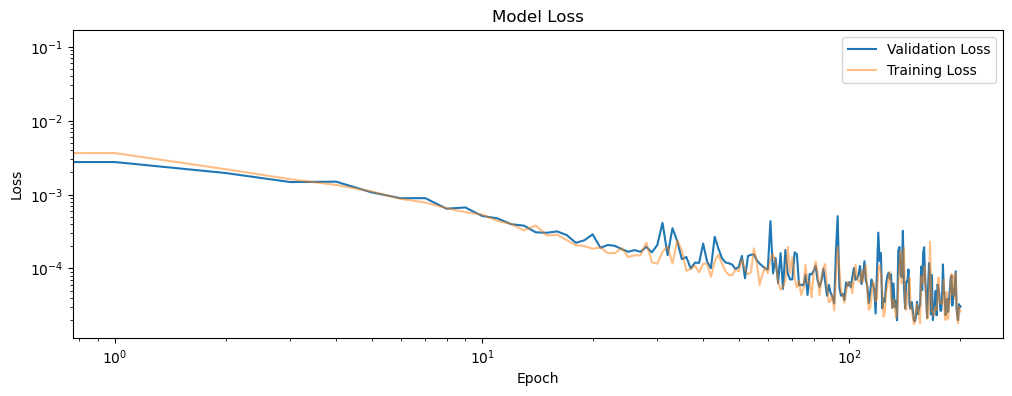

In [7]:
# Plot training & validation loss values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
#plt.loglog(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.loglog(history.history['loss'], label='Training Loss', alpha=0.5)

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# model_fixed.save("emulator_sigma_As_fixed.keras")

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 mean, std de ratio de HMF
0.9981921204567996
0.020657849611477066

RMSE sigma on the testset: 0.0008398738299691081
MAE sigma on the test set: 0.0005145092295847163


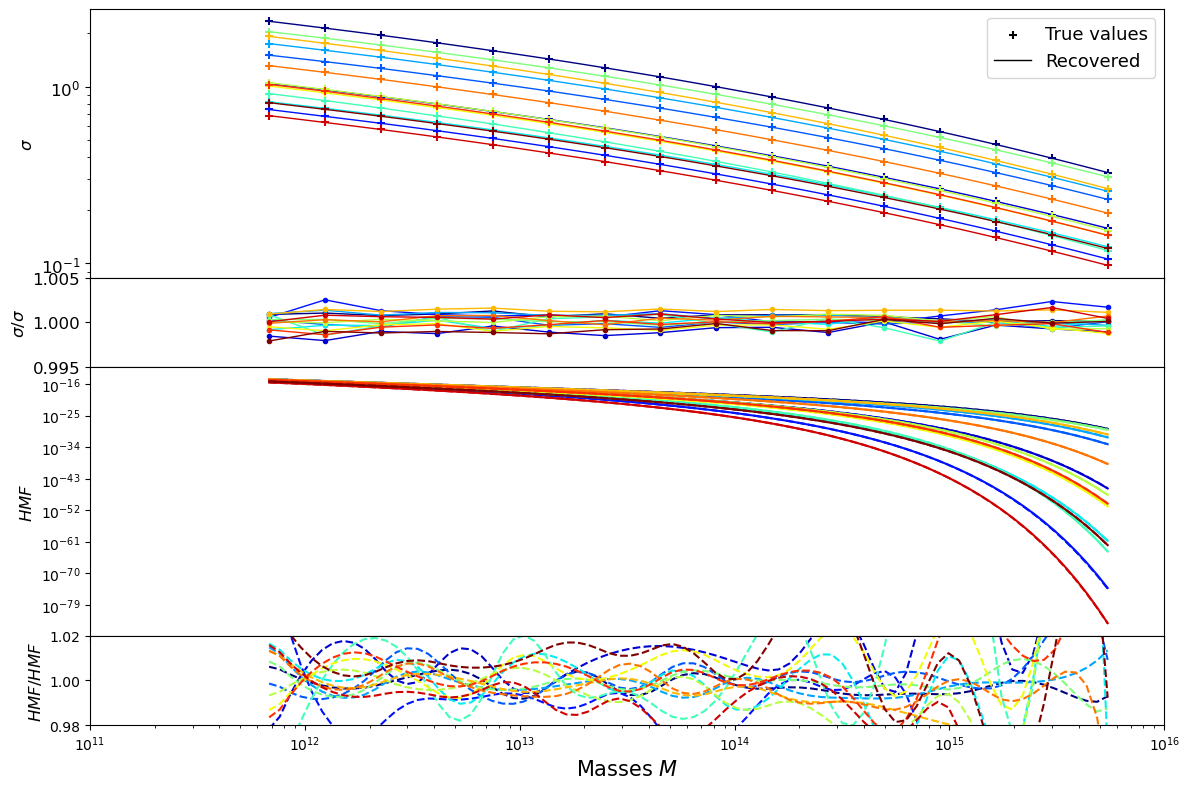

In [ ]:
# # Make predictions on the scaled test set
# Y_test_pred_scaled = model.predict(X_test_scaled)
# Y_test_pred = scaler_Y.inverse_transform(Y_test_pred_scaled) # Convert back from log scale

# As = 2e-9
# ntrace = 15
    
# colors = plt.cm.jet(np.linspace(0,1,ntrace))# Initialize holder for trajectories

    
# new_xx = np.logspace(np.log10(np.min(allM)),np.log10(np.max(allM)) , 80)

# ini0 = np.random.uniform(low=0, high=np.shape(X_test)[0],size=ntrace)
                        
# fig, axes = plt.subplots(4,1,figsize=(12,8),sharex=True,gridspec_kw={'height_ratios':(3,1,3,1),'hspace':0})

# ratios = []
    
# for i in np.arange(ntrace):
#     ini = np.int32(ini0[i])


#     redshift = [X_test[ini,6]] 

#     pars = camb.CAMBparams()
#     pars.set_cosmology(H0=X_test[ini,4], ombh2=X_test[ini,5], omch2=X_test[ini,2], mnu = 0, omk=0, tau=0.0561)
#     pars.InitPower.set_params(As=As, ns=X_test[ini,3], r=0)
#     pars.set_for_lmax(2500, lens_potential_accuracy=0)
#     #pars.NonLinear = model.NonLinear_both
#     pars.set_matter_power(redshifts=redshift, kmax=10, silent=True)
#     pars.set_dark_energy(w=X_test[ini,0], wa=X_test[ini,1], dark_energy_model='ppf')


   
        
#     axes[0].scatter(allM, (y_test[ini,:]), marker="+", color=colors[i], s=30, zorder=2)

#     new_yy = sp.interpolate.interp1d(np.log(allM), Y_test_pred[ini,:] , kind='cubic', fill_value='extrapolate')(np.log(new_xx))
        
#     axes[0].plot(new_xx, new_yy, "-", color=colors[i], lw=1., zorder=1)

        
#     axes[1].plot(allM, (y_test[ini,:])/Y_test_pred[ini,:],marker='o',color=colors[i],lw=1,markersize=3)


#     yyi = sp.interpolate.interp1d(np.log(allM), y_test[ini, :], kind='cubic', fill_value='extrapolate')(np.log(new_xx))
        
#     hmfp = massfunction_Tinker_M500C(new_xx, redshift[0],new_yy,  pars)
        
#     hmf = massfunction_Tinker_M500C(new_xx, redshift[0], yyi,  pars)

#     axes[2].plot(new_xx, hmf,color=colors[i])
#     axes[2].plot(new_xx,hmfp, "--", color=colors[i])
#     #axes[3].plot(allM, hmfp/hmf,color=colors[i])
#     axes[3].plot(new_xx, hmfp/hmf, "--",color=colors[i])

#     ratios.append( np.mean(hmfp/hmf))

        
# axes[2].loglog()

# axes[0].scatter([], [], marker="+", color='k', s=30, label='True values')
# axes[0].plot([], [], color='k', lw=1., label='Recovered')
# axes[0].legend(loc='best', fontsize=13)
# axes[0].loglog()
# axes[0].set_xlim(1e11, 1e16)
# axes[3].set_xlabel(r"Masses $M$", fontsize=15)
# axes[1].set_ylim(0.995, 1.005)
# axes[3].set_ylim(0.98, 1.02)
# axes[0].set_ylabel(r"$\sigma$", fontsize=12)
# axes[1].set_ylabel(r"$\sigma/\sigma$", fontsize=12)
# axes[3].set_ylabel(r"$HMF/HMF$", fontsize=12)
# axes[2].set_ylabel(r"$HMF$", fontsize=12)
   
# axes[0].tick_params(labelsize=12)
# axes[1].tick_params(labelsize=12)
# fig.tight_layout()

# print(" mean, std de ratio de HMF")
# print(np.mean(ratios))
# print(np.std(ratios))


# rmse_original = np.sqrt(mean_squared_error(y_test, Y_test_pred))
# mae_original = mean_absolute_error(y_test, Y_test_pred)
# print("\nRMSE sigma on the testset:", rmse_original)
# print("MAE sigma on the test set:", mae_original)

#### Training model As Flex

In [10]:

# training_file = "./Training_hmf_24Mass.txt"
training_file = "./Training_sigma_24_z0.txt"

allM = np.genfromtxt("Training_sigma_24M_Masses.txt")

dataset2 = np.genfromtxt(training_file)

nsampt = np.shape(dataset2)[0]

XX2 = np.copy(dataset2[:, 0:7])

YY2 = np.copy(dataset2[:, 11:])



In [11]:
X_tmp2, X_test2, y_tmp2, y_test2 = train_test_split(XX2, YY2, test_size=0.1, random_state=42)
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_tmp2, y_tmp2, test_size=0.2, random_state=42)

scaler_X2 = StandardScaler()
X_train_scaled2 = scaler_X2.fit_transform(X_train2)
X_val_scaled2 = scaler_X2.transform(X_val2)
# X_test_scaled = scaler_X.transform(X_test2)
print("\nInput Features normalised RobustScaler:")
print("X_train_scaled:")
print(X_val_scaled2[:2])

scaler_Y2 = RobustScaler()
y_train_scaled2 = scaler_Y2.fit_transform(y_train2)
y_val_scaled2 = scaler_Y2.transform(y_val2)
y_test_scaled2 = scaler_Y2.transform(y_test2)

print("\nOutput Features normalised by Logarit:")
print("y_train_log:")
print(y_train_scaled2[:2])
print(X_test2.shape)



Input Features normalised RobustScaler:
X_train_scaled:
[[-1.07232451  1.34848026 -0.22441802  1.6767521  -1.68279605 -1.28534862
   0.53637552]
 [ 1.52004194  0.06191345 -1.39146126 -0.02941027 -1.15757562 -1.72523822
   1.5045367 ]]

Output Features normalised by Logarit:
y_train_log:
[[0.51800696 0.51882609 0.51705376 0.51548312 0.51236837 0.51259275
  0.51197199 0.51395476 0.51338921 0.51340036 0.51337879 0.51330658
  0.51305015 0.51517591 0.51336697 0.51436433 0.51433362 0.51450156
  0.51241173 0.51443175 0.5113831  0.51213294 0.50893215 0.5071934 ]
 [0.64317835 0.65087226 0.65632515 0.66192711 0.66644333 0.67455179
  0.68211039 0.69198247 0.69891876 0.70694269 0.71501346 0.72309727
  0.73198646 0.74461734 0.75294952 0.76396617 0.77324491 0.78379371
  0.79307686 0.80564807 0.81466157 0.82808792 0.83708093 0.84716159]]
(1000, 7)


In [13]:
import tensorflow as tf



from tensorflow import keras
from tensorflow.keras import layers


model_flex = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(X_train_scaled2.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(24, activation='linear')
])


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)


#model.compile(optimizer='adam',loss='mse', metrics=['accuracy'])
model_flex.compile(optimizer='adam',loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])
# Train the model with validation data

history2 = model_flex.fit(X_train_scaled2, y_train_scaled2, epochs=800, batch_size=100, validation_data=(X_val_scaled2, y_val_scaled2)
                    ,callbacks=[early_stopping]
                    )

Epoch 1/800


c:\Users\MAIYP\anaconda3\envs\CosmoCNRS\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1200 - mean_squared_error: 0.1200 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 2/800
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 3/800
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 4/800
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 5/800
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 6/800
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 7/800
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0010 - val_mean_squar

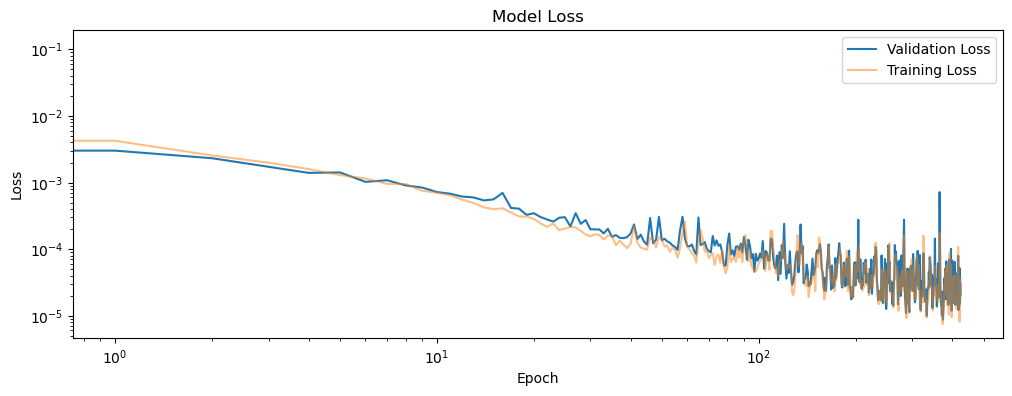

In [14]:
# Plot training & validation loss values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
#plt.loglog(history.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.loglog(history2.history['loss'], label='Training Loss', alpha=0.5)

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# model_fixed.save("emulator_sigma_As_fixed.keras")

#### test the predicted values ​​of the two models

In [37]:
#test_set is computed by CAMB
X_CAMB = X_test2
y_CAMB = y_test2

#Drop As column for model_fixed
X_CAMB_fixed = np.delete(X_CAMB, 2, axis=1)
X_CAMB_fixed_scaled = scaler_X1.transform(X_CAMB_fixed)

#Make predictions on the testset model_fixed
y_pred_fixed_scaled = model_fixed.predict(X_CAMB_fixed_scaled)
y_pred_fixed = scaler_Y1.inverse_transform(y_pred_fixed_scaled) #Sigma As=2e-9

#Compute Scaling As 
rescale_facor = np.sqrt(X_CAMB[:, 2] / (2e-9))
sigma_As_fixed = y_pred_fixed * rescale_facor[:, np.newaxis]

#Make predictions on the model_flex
X_test_flex_scaled = scaler_X2.transform(X_CAMB)
y_pred_flex_scaled = model_flex.predict(X_test_flex_scaled)
sigma_As_flex = scaler_Y2.inverse_transform(y_pred_flex_scaled)



32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [ ]:

if y_CAMB.shape != sigma_As_fixed.shape or y_CAMB.shape != sigma_As_flex.shape:
    print("ERROR: Array sizes do not match. Please check your calculation again.")
else:
    # Calculate RE for the Fixed model As
    # RE = |(pred - real) / real|
    error_fixed = np.abs((sigma_As_fixed - y_CAMB) / y_CAMB)

    # Calculate RE for the flex model As
    error_flex = np.abs((sigma_As_flex - y_CAMB) / y_CAMB)

    # Handle division by zero and infinite values
    error_fixed[np.isinf(error_fixed)] = 0
    error_flex[np.isinf(error_flex)] = 0

In [ ]:
# Calculate (Mean Relative Error - MRE)
mre_fixed = np.mean(error_fixed) * 100
mre_flex = np.mean(error_flex) * 100

# Calculate (Max Relative Error)
max_err_fixed = np.max(error_fixed) * 100
max_err_flex = np.max(error_flex) * 100

print("\n--- Performance Rating (In %) ---")
print(f"Fixed As + Rescaling:")
print(f"  Mean Relative Error: {mre_fixed:.3f}%")
print(f"  Max Error : {max_err_fixed:.3f}%")
print("\n model Flex As - As learned):")
print(f"  Mean RE: {mre_flex:.3f}%")
print(f"  Max Error : {max_err_flex:.3f}%")

if mre_fixed < mre_flex:
    print("\n=> The Fixed As model is giving more accurate results on average.")
elif mre_flex < mre_fixed:
    print("\n=> The Flexible As (Flex) model is giving more accurate average results.")
else:
    print("\n=> The two models have similar average accuracy.")


--- Performance Rating (In %) ---
Fixed As + Rescaling:
  Mean Relative Error: 0.040%
  Max Error : 1.278%

 model Flex As - As learned):
  Mean RE: 0.038%
  Max Error : 0.677%

=> The Flexible As (Flex) model is giving more accurate average results.


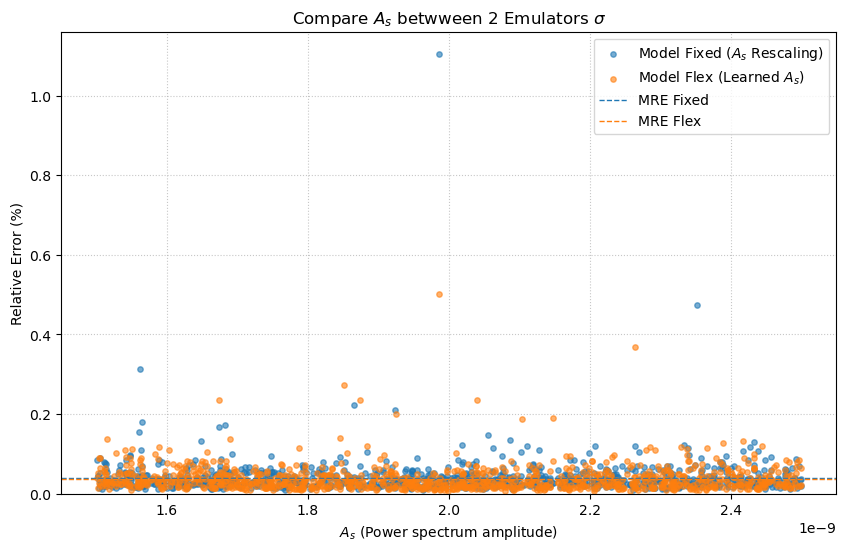

In [46]:
import matplotlib.pyplot as plt


As_values = X_CAMB[:, 2]


mean_error_fixed_per_sample = np.mean(error_fixed, axis=1) * 100
mean_error_flex_per_sample = np.mean(error_flex, axis=1) * 100

plt.figure(figsize=(10, 6))

# Scatter plot
plt.scatter(As_values, mean_error_fixed_per_sample, label='Model Fixed ($A_s$ Rescaling)', alpha=0.6, s=15, color='tab:blue')
plt.scatter(As_values, mean_error_flex_per_sample, label='Model Flex (Learned $A_s$)', alpha=0.6, s=15, color='tab:orange')

plt.axhline(y=np.mean(mean_error_fixed_per_sample), color='tab:blue', linestyle='--', linewidth=1, label='MRE Fixed')
plt.axhline(y=np.mean(mean_error_flex_per_sample), color='tab:orange', linestyle='--', linewidth=1, label='MRE Flex')


plt.xlabel(r'$A_s$ (Power spectrum amplitude)')
plt.ylabel('Relative Error (%)')
plt.title('Compare $A_s$ betwween 2 Emulators $\sigma$')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.ylim(bottom=0)
plt.show()
# 



#### the influence of sigma from 2 models on HMF (at z=0)

In [74]:
n_samples = X_CAMB.shape[0]
Masses_interp = np.logspace(np.log10(np.min(allM)), np.log10(np.max(allM)), 80)
N_MASSES_INTERP = Masses_interp.size
HMF_RE_Fixed = np.zeros((n_samples, N_MASSES_INTERP))
HMF_RE_Flex = np.zeros((n_samples, N_MASSES_INTERP))
for sample_index in range(n_samples):


    cosmo_params = X_CAMB[sample_index, [0, 1, 3, 4, 5, 6]]
    w0, wa, omch2, ns, H0, ombh2 = cosmo_params
    z_val = 0

    Masses = np.logspace(np.log10(np.min(allM)), np.log10(np.max(allM)), 80)

    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=0, omk=0, tau=0.0561)
    pars.InitPower.set_params(As=X_CAMB[sample_index, 2], ns=ns)
    pars.set_dark_energy(w=w0, wa=wa, dark_energy_model='ppf')

    sigma_CAMB_orig = y_CAMB[sample_index, :]
    sigma_Fixed_orig = sigma_As_fixed[sample_index, :]
    sigma_Flex_orig = sigma_As_flex[sample_index, :] 

    interp_func = sp.interpolate.interp1d(np.log(allM), sigma_CAMB_orig, kind='cubic', fill_value='extrapolate')
    sigma_CAMB = interp_func(np.log(Masses))

    interp_func = sp.interpolate.interp1d(np.log(allM), sigma_Fixed_orig, kind='cubic', fill_value='extrapolate')
    sigma_Fixed = interp_func(np.log(Masses))

    interp_func = sp.interpolate.interp1d(np.log(allM), sigma_Flex_orig, kind='cubic', fill_value='extrapolate')
    sigma_Flex = interp_func(np.log(Masses))

    # Compute HMF 

    # HMF true (Ground Truth)
    HMF_CAMB = massfunction_Tinker_M500C(Masses, z_val, sigma_CAMB, pars)

    # HMF from Model fixed As
    HMF_Fixed = massfunction_Tinker_M500C(Masses, z_val, sigma_Fixed, pars)

    # HMF from Model Flex As
    HMF_Flex = massfunction_Tinker_M500C(Masses, z_val, sigma_Flex, pars)

    re_fixed = np.abs((HMF_Fixed - HMF_CAMB) / HMF_CAMB) * 100
    HMF_RE_Fixed[sample_index, :] = re_fixed
    re_flex = np.abs((HMF_Flex - HMF_CAMB) / HMF_CAMB) * 100
    HMF_RE_Flex[sample_index, :] = re_flex

print(f"Successfully computed HMF error for 2 models on {n_samples} samples")

C:\Users\MAIYP\AppData\Local\Temp\ipykernel_9208\2384099019.py:24: DeprecationWarning: Please import `interp1d` from the `scipy.interpolate` namespace; the `scipy.interpolate.interpolate` namespace is deprecated and will be removed in SciPy 2.0.0.
  interp_func = sp.interpolate.interp1d(np.log(allM), sigma_CAMB_orig, kind='cubic', fill_value='extrapolate')
C:\Users\MAIYP\AppData\Local\Temp\ipykernel_9208\2384099019.py:27: DeprecationWarning: Please import `interp1d` from the `scipy.interpolate` namespace; the `scipy.interpolate.interpolate` namespace is deprecated and will be removed in SciPy 2.0.0.
  interp_func = sp.interpolate.interp1d(np.log(allM), sigma_Fixed_orig, kind='cubic', fill_value='extrapolate')
C:\Users\MAIYP\AppData\Local\Temp\ipykernel_9208\2384099019.py:30: DeprecationWarning: Please import `interp1d` from the `scipy.interpolate` namespace; the `scipy.interpolate.interpolate` namespace is deprecated and will be removed in SciPy 2.0.0.
  interp_func = sp.interpolate.in

Successfully computed HMF error for 2 models on 1000 samples


In [91]:

max_index_flat = np.argmax(HMF_RE_Fixed)
max_indices = np.unravel_index(max_index_flat, HMF_RE_Fixed.shape)

sample_index_max_error = max_indices[0] 
mass_index_max_error = max_indices[1] 

print(f"Maximum Error: {np.max(HMF_RE_Fixed):.2f}%")
print(f"Appears in Parameter Set (row): {sample_index_max_error}")
print(f"Appears at Mass Point (column): {mass_index_max_error}")

Maximum Error: 121.15%
Appears in Parameter Set (row): 430
Appears at Mass Point (column): 79


#### HMF predictions have a relative error greater than 2%

In [90]:
THRESHOLD_PERCENT = 10
mask_fixed = HMF_RE_Fixed > THRESHOLD_PERCENT
mask_flex = HMF_RE_Flex > THRESHOLD_PERCENT


count_fixed = np.sum(mask_fixed)
count_flex = np.sum(mask_flex)

total_data_points = HMF_RE_Fixed.size

print(f"Error Rating (Threshold > {THRESHOLD_PERCENT}%) ")
print(f"Total number of data points: {total_data_points}")
print("-" * 40)
print(f"Model As Fixed (Rescaling):")
print(f"  Number errors > {THRESHOLD_PERCENT}%: {count_fixed} points")
print(f"  High error rate: {count_fixed / total_data_points * 100:.3f}%")
print("-" * 40)
print(f"Model As Flex (Learned As):")
print(f"  Number Error > {THRESHOLD_PERCENT}%: {count_flex} points")
print(f"   error rate: {count_flex / total_data_points * 100:.3f}%")

Error Rating (Threshold > 10%) 
Total number of data points: 80000
----------------------------------------
Model As Fixed (Rescaling):
  Number errors > 10%: 70 points
  High error rate: 0.088%
----------------------------------------
Model As Flex (Learned As):
  Number Error > 10%: 101 points
   error rate: 0.126%


In [68]:
## RE HMF
RE_As_fixed = np.abs((HMF_Fixed - HMF_CAMB) / HMF_CAMB) * 100
RE_As_flex = np.abs((HMF_Flex - HMF_CAMB) / HMF_CAMB) * 100
print(f"The RE of HMF As Fixed is {np.mean(RE_As_fixed)} ...")
print(f"The RE of HMF As Flex is {np.mean(RE_As_flex)} ...")

The RE of HMF As Fixed is 0.5157250434100991 ...
The RE of HMF As Flex is 0.43674682862253056 ...


In [69]:
print(f"The values of HMF CAMB is {HMF_CAMB[-5:]} ")
print(f"The values of HMF As Fixed is {HMF_Fixed[-5:]} ")
print(f"The values of HMF As Flex is {HMF_Flex[-5:]} ")


The values of HMF CAMB is [2.27722721e-29 5.18171197e-30 1.05807085e-30 1.91996688e-31
 3.15763677e-32] 
The values of HMF As Fixed is [2.31926508e-29 5.29447976e-30 1.08384847e-30 1.96810114e-31
 3.22368332e-32] 
The values of HMF As Flex is [2.28658262e-29 5.22126450e-30 1.06719427e-30 1.92838786e-31
 3.12124990e-32] 


### z_scale(z=3) from model is trained (z=0) and model is trained by dataset (z=3)

#### Create a model from a dataset(z=3)

In [112]:

# training_file = "./Training_hmf_24Mass.txt"


# allM = np.genfromtxt("./Training_sigma_24M_Masses.txt")

dataset3 = np.genfromtxt("Training_sigma_24M_z3.txt")

nsampt3 = np.shape(dataset3)[0]

temp_selection3 = np.copy(dataset3[:, 0:7])
XX3 = np.delete(temp_selection3, 2, axis=1) #Remove As column
YY3 = np.copy(dataset3[:, 11:])



In [115]:
X_tmp3, X_test3, y_tmp3, y_test3 = train_test_split(XX3, YY3, test_size=0.1, random_state=42)
X_train3, X_val3, y_train3, y_val3 = train_test_split(X_tmp3, y_tmp3, test_size=0.2, random_state=42)

scaler_X3 = StandardScaler()
X_train_scaled3 = scaler_X3.fit_transform(X_train3)
X_val_scaled3 = scaler_X3.transform(X_val3)
X_test_scaled3 = scaler_X3.transform(X_test3)
print("\nInput Features normalised RobustScaler:")
print("X_train_scaled:")
print(X_val_scaled3[:2])

scaler_Y3 = RobustScaler()
y_train_scaled3 = scaler_Y3.fit_transform(y_train3)
y_val_scaled3 = scaler_Y3.transform(y_val3)
y_test_scaled3 = scaler_Y3.transform(y_test3)

print("\nOutput Features normalised by Logarit:")
print("y_train_log:")
print(y_train_scaled3[:2])




Input Features normalised RobustScaler:
X_train_scaled:
[[ 0.03590815 -0.17418886 -1.30028564 -0.53297042  0.57093802 -1.3821193 ]
 [-0.28042647 -1.29154289  1.35559408 -1.62940157  1.17204091 -1.43535609]]

Output Features normalised by Logarit:
y_train_log:
[[-0.2937806  -0.29518047 -0.29627696 -0.29605757 -0.2963104  -0.29943969
  -0.29649487 -0.29577414 -0.29507447 -0.29304239 -0.28948943 -0.29196881
  -0.29023794 -0.28843045 -0.28961984 -0.28652923 -0.28331071 -0.27969879
  -0.2779529  -0.27672785 -0.27258062 -0.26823042 -0.25843199 -0.24606108]
 [ 0.34127038  0.33431411  0.32718815  0.32014659  0.31165192  0.3025966
   0.29718495  0.28805493  0.27705417  0.26585329  0.25417091  0.24094976
   0.22650658  0.21136866  0.19280876  0.1723614   0.15120723  0.12619134
   0.09597983  0.0618881   0.02504931 -0.01768159 -0.06142283 -0.10974008]]


In [116]:

model_fixed_z3 = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(X_train_scaled1.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(24, activation='linear')
])


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)


#model.compile(optimizer='adam',loss='mse', metrics=['accuracy'])
model_fixed_z3.compile(optimizer='adam',loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])
# Train the model with validation data

history3 = model_fixed_z3.fit(X_train_scaled3, y_train_scaled3, epochs=800, batch_size=100, validation_data=(X_val_scaled3, y_val_scaled3)
                    ,callbacks=[early_stopping]
                    )

Epoch 1/800


c:\Users\MAIYP\anaconda3\envs\CosmoCNRS\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1030 - mean_squared_error: 0.1030 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 2/800
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 3/800
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 4/800
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 5/800
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 6/800
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 7/800
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0012 - val_mean_squar

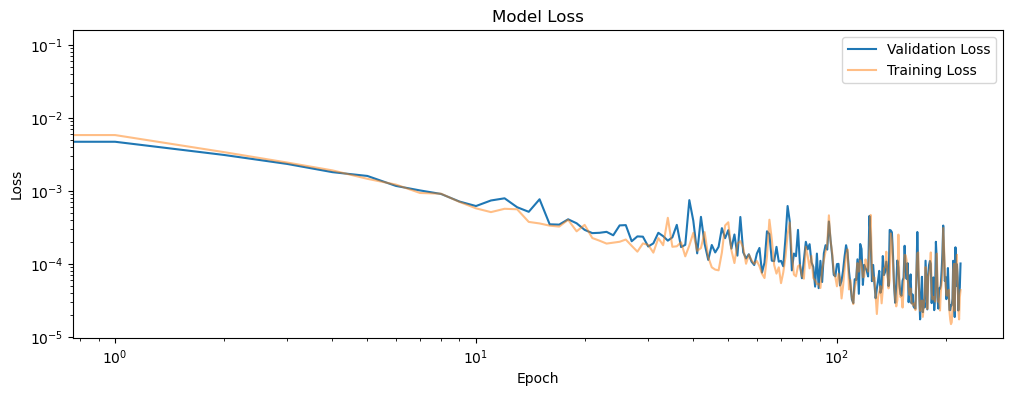

In [117]:
# Plot training & validation loss values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
#plt.loglog(history.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.loglog(history3.history['loss'], label='Training Loss', alpha=0.5)

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# model_fixed_z3.save("emulator_sigma_As_fixed_z3.keras")

#### Compare the performance between 2 approachs (scaling z and fixed z)

In [5]:
import sys
import numpy as np
import camb
from camb import model, initialpower
import matplotlib.pyplot as plt
from scipy.stats import qmc
from scipy.integrate import quad
import os


def growth_factor(z, Omega_m0=0.3, w=-1.0, wa=0, gamma=None):
    """
    Linear growth factor D(z), normalized to D(0)=1.

    Parameters
    ----------
    z : float or array
        Redshift(s)
    Omega_m0 : float
        Present-day matter density fraction (default 0.3)
    w : float
        Dark energy equation of state (default -1 for LCDM)
    gamma : float or None
        Growth index (if None, use Linder formula: 0.55+0.05*(1+w))
    """

    
    w1 = w + wa*1/(1.+1)  # effective w at z=1 for gamma approximation

    # growth index
    if gamma is None:
        if wa != 0:
            gamma = 0.55 + 0.05 * (1 + w1)  # Linder (2005)
            if w < -1:
                gamma = 0.55 + 0.02 * (1 + w1)
        else:
        # more accurate formula from arXiv:2411.00963
            gamma = 0.0068*w1+ 0.1346*np.exp( 2.8453*w1)+0.5493 #https://arxiv.org/pdf/2411.00963


    def E(z):
        return np.sqrt(Omega_m0 * (1+z)**3 + (1 - Omega_m0) * (1+z)**(3*(1+w+wa))*np.exp(-3*wa*z/(1+z)))

    def Omega_m(z):
        return Omega_m0 * (1+z)**3 / E(z)**2

    def integrand(z):
        return (Omega_m(z)**gamma) / (1+z)

    def D_single(z):
        integral, _ = quad(integrand, 0, z)
        return np.exp(-integral) #/ (1+z)

    if np.isscalar(z):
        return D_single(z)
    else:
        return np.array([D_single(zi) for zi in z])


In [126]:
X_test_scaledz0 = scaler_X1.transform(X_test3)   #Normalisation X_test for model z=0

#Model z=3
y_z3_scaled = model_fixed_z3.predict(X_test_scaled3)
y_z3 = scaler_Y3.inverse_transform(y_z3_scaled)

#Model z=0
y_z0_scaled = model_fixed.predict(X_test_scaledz0)
y_z0 = scaler_Y1.inverse_transform(y_z0_scaled)




32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [147]:
#Calulate D(z=3) on the test set
z_target = 3
nb_samples = X_test3.shape[0]
sigma_z3_all = np.zeros_like(y_z0)
for i in range (nb_samples):
    cosmo_params1 = X_test3[i, :]
    w0 = cosmo_params1[0]
    wa = cosmo_params1[1]
    omch2 = cosmo_params1[2]
    H0 = cosmo_params1[4]
    ombh2 = cosmo_params1[5]

    h = H0 / 100
    omega_m0 = (ombh2 + omch2) / (h**2) 
    D_z3 = growth_factor(z = z_target, Omega_m0=omega_m0, w=w0, wa = wa)

    sigma_z0 = y_z0[i, :]
    sigma_z3_all[i, :] = sigma_z0 * D_z3


print(f"All of sigma has been scaled from 0 to {z_target}")
print(f"The dimension is {sigma_z3_all.shape}")


All of sigma has been scaled from 0 to 3
The dimension is (1000, 24)


#### Relative Error on the model fixed z=3 vs CAMB (%)

In [ ]:
RE_sigma_z3 = np.abs((y_z3 - y_test3)/y_test3) * 100


[[0.01250669 0.03023035 0.00572592 0.00475325 0.00825695 0.01060974
  0.00658453 0.00140505 0.01405222 0.0075038  0.00044839 0.02038845
  0.01106827 0.00580641 0.01291776 0.02495474 0.00577588 0.00291769
  0.01366992 0.00495369 0.00506259 0.01788261 0.01618571 0.0071763 ]
 [0.05231697 0.01185089 0.06086948 0.05375269 0.00042067 0.02342805
  0.04498889 0.06371011 0.00802581 0.02725822 0.05582335 0.00684772
  0.02865796 0.03139608 0.04794722 0.00938994 0.02627311 0.01503431
  0.00066935 0.0360271  0.02546082 0.00011051 0.04415496 0.0405131 ]]


#### RE on the model that was scaling z vs CAMB (%)

In [155]:
RE_sigma_z3_scaled = np.abs((sigma_z3_all - y_test3)/y_test3) * 100


#### Compare 2 models (RE)

In [158]:
# Calculate (Mean Relative Error - MRE)
mre_fixed_z = np.mean(RE_sigma_z3) 
mre_scaled_z = np.mean(RE_sigma_z3_scaled) 

# Calculate (Max Relative Error)
max_err_fixed_z = np.max(RE_sigma_z3) 
max_err_scaled_z = np.max(RE_sigma_z3_scaled) 

print("\n--- Performance Rating (In %) ---")
print(f"Fixed z :")
print(f"  Mean Relative Error: {mre_fixed_z:.3f}%")
print(f"  Max Error : {max_err_fixed_z:.3f}%")
print("\n model Scaling z :")
print(f"  Mean RE: {mre_scaled_z:.3f}%")
print(f"  Max Error : {max_err_scaled_z:.3f}%")

if mre_fixed_z < mre_scaled_z:
    print("\n=> The Fixed z model is giving more accurate results on average.")
elif mre_scaled_z < mre_fixed_z:
    print("\n=> The Scaled z model is giving more accurate average results.")
else:
    print("\n=> The two models have similar average accuracy.")


--- Performance Rating (In %) ---
Fixed z :
  Mean Relative Error: 0.031%
  Max Error : 1.090%

 model Scaling z :
  Mean RE: 0.087%
  Max Error : 1.090%

=> The Fixed z model is giving more accurate results on average.


#### The influence on HMF (z = 3)

In [164]:
n_samples = X_test3.shape[0]
Masses_interp = np.logspace(np.log10(np.min(allM)), np.log10(np.max(allM)), 80)
N_MASSES_INTERP = Masses_interp.size
HMF_RE_zFixed = np.zeros((n_samples, N_MASSES_INTERP))
HMF_RE_zScaled = np.zeros((n_samples, N_MASSES_INTERP))
As = 2e-9
for sample_index in range(n_samples):


    cosmo_params = X_test3[sample_index]
    w0, wa, omch2, ns, H0, ombh2 = cosmo_params
    z_val = 3

    Masses = np.logspace(np.log10(np.min(allM)), np.log10(np.max(allM)), 80)

    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=0, omk=0, tau=0.0561)
    pars.InitPower.set_params(As=As, ns=ns)
    pars.set_dark_energy(w=w0, wa=wa, dark_energy_model='ppf')

    sigma_CAMB_orig = y_test3[sample_index, :]
    sigma_zFixed_orig = y_z3[sample_index, :]
    sigma_zScaled_orig = sigma_z3_all[sample_index, :] 

    interp_func = sp.interpolate.interp1d(np.log(allM), sigma_CAMB_orig, kind='cubic', fill_value='extrapolate')
    sigma_CAMB = interp_func(np.log(Masses))

    interp_func = sp.interpolate.interp1d(np.log(allM), sigma_zFixed_orig, kind='cubic', fill_value='extrapolate')
    sigma_zFixed = interp_func(np.log(Masses))

    interp_func = sp.interpolate.interp1d(np.log(allM), sigma_zScaled_orig, kind='cubic', fill_value='extrapolate')
    sigma_zScaled = interp_func(np.log(Masses))

    # Compute HMF 

    # HMF true (Ground Truth)
    HMF_CAMB = massfunction_Tinker_M500C(Masses, z_val, sigma_CAMB, pars)

    # HMF from Model fixed As
    HMF_zFixed = massfunction_Tinker_M500C(Masses, z_val, sigma_zFixed, pars)

    # HMF from Model Flex As
    HMF_zScaled = massfunction_Tinker_M500C(Masses, z_val, sigma_zScaled, pars)

    re_zfixed = np.abs((HMF_zFixed - HMF_CAMB) / HMF_CAMB) * 100
    HMF_RE_zFixed[sample_index, :] = re_zfixed
    re_zScaled = np.abs((HMF_zScaled - HMF_CAMB) / HMF_CAMB) * 100
    HMF_RE_zScaled[sample_index, :] = re_zScaled

print(f"Successfully computed HMF error for 2 models on {n_samples} samples")

C:\Users\MAIYP\AppData\Local\Temp\ipykernel_9208\1781706061.py:25: DeprecationWarning: Please import `interp1d` from the `scipy.interpolate` namespace; the `scipy.interpolate.interpolate` namespace is deprecated and will be removed in SciPy 2.0.0.
  interp_func = sp.interpolate.interp1d(np.log(allM), sigma_CAMB_orig, kind='cubic', fill_value='extrapolate')
C:\Users\MAIYP\AppData\Local\Temp\ipykernel_9208\1781706061.py:28: DeprecationWarning: Please import `interp1d` from the `scipy.interpolate` namespace; the `scipy.interpolate.interpolate` namespace is deprecated and will be removed in SciPy 2.0.0.
  interp_func = sp.interpolate.interp1d(np.log(allM), sigma_zFixed_orig, kind='cubic', fill_value='extrapolate')
C:\Users\MAIYP\AppData\Local\Temp\ipykernel_9208\1781706061.py:31: DeprecationWarning: Please import `interp1d` from the `scipy.interpolate` namespace; the `scipy.interpolate.interpolate` namespace is deprecated and will be removed in SciPy 2.0.0.
  interp_func = sp.interpolate.i

Successfully computed HMF error for 2 models on 1000 samples


In [165]:

max_index_flat = np.argmax(HMF_RE_zFixed)
max_indices = np.unravel_index(max_index_flat, HMF_RE_zFixed.shape)

sample_index_max_error = max_indices[0] 
mass_index_max_error = max_indices[1] 

print(f"Maximum Error: {np.max(HMF_RE_zFixed):.2f}%")
print(f"Appears in Parameter Set (row): {sample_index_max_error}")
print(f"Appears at Mass Point (column): {mass_index_max_error}")

Maximum Error: 9723.81%
Appears in Parameter Set (row): 885
Appears at Mass Point (column): 79


In [173]:
THRESHOLD_PERCENT = 5
mask_zfixed = HMF_RE_zFixed > THRESHOLD_PERCENT
mask_zScaled = HMF_RE_zScaled > THRESHOLD_PERCENT


count_fixed = np.sum(mask_zfixed)
count_flex = np.sum(mask_zScaled)

total_data_points = HMF_RE_zFixed.size

print(f"Error Rating (Threshold > {THRESHOLD_PERCENT}%) ")
print(f"Total number of data points: {total_data_points}")
print("-" * 40)
print(f"Model z fixed :")
print(f"  Number errors > {THRESHOLD_PERCENT}%: {count_fixed} points")
print(f"  High error rate: {count_fixed / total_data_points * 100:.3f}%")
print("-" * 40)
print(f"Model z Scaled :")
print(f"  Number Error > {THRESHOLD_PERCENT}%: {count_flex} points")
print(f"   error rate: {count_flex / total_data_points * 100:.3f}%")

Error Rating (Threshold > 5%) 
Total number of data points: 80000
----------------------------------------
Model z fixed :
  Number errors > 5%: 6074 points
  High error rate: 7.593%
----------------------------------------
Model z Scaled :
  Number Error > 5%: 20583 points
   error rate: 25.729%


#### plot les values pour montrer les grandes erreurs se concentre à grande Mass

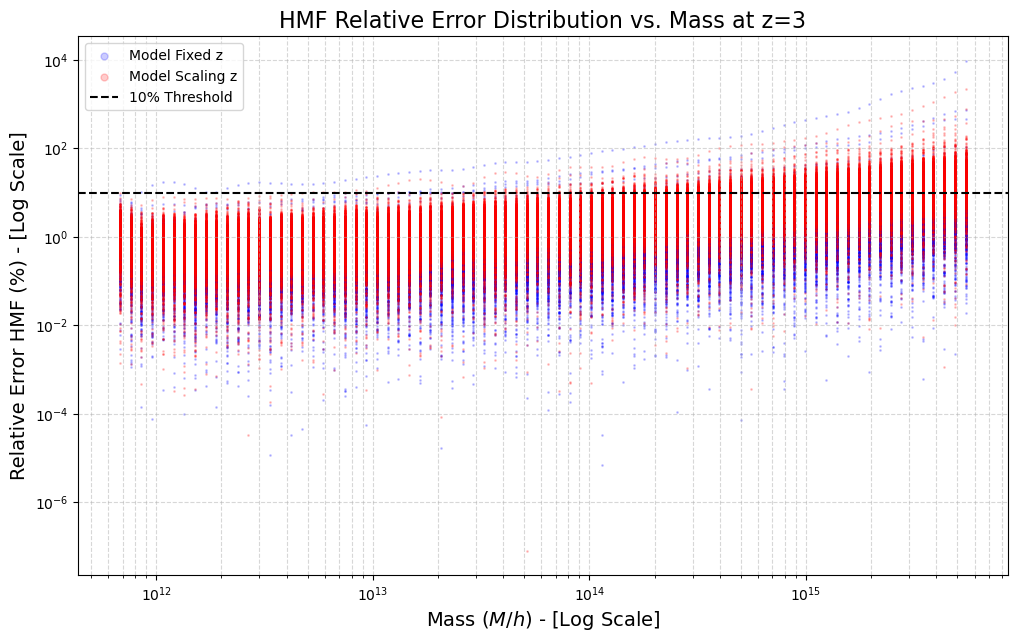

In [ ]:



RE_fixed_flat = HMF_RE_zFixed.flatten() 
RE_scaled_flat = HMF_RE_zScaled.flatten() 


N_samples = HMF_RE_zFixed.shape[0] # 1000
Mass_flat = np.tile(Masses_interp, N_samples) 



plt.figure(figsize=(12, 7))


plt.scatter(
    Mass_flat, 
    RE_fixed_flat, 
    s=1,
    alpha=0.2, 
    label='Model Fixed z', 
    color='blue'
)


plt.scatter(
    Mass_flat, 
    RE_scaled_flat, 
    s=1, 
    alpha=0.2, 
    label='Model Scaling z', 
    color='red'
)


plt.xscale('log') 
plt.yscale('log') 


plt.xlabel(r'Mass ($M / h$) - [Log Scale]', fontsize=14)
plt.ylabel('Relative Error HMF (%) - [Log Scale]', fontsize=14)
plt.title(f'HMF Relative Error Distribution vs. Mass at z={z_target}', fontsize=16)


plt.axhline(y=10, color='black', linestyle='--', linewidth=1.5, label='10% Threshold')

plt.legend(markerscale=5) 
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

#

### Create a "Mock Data" from the Plank 2018 (Lambda CBM)
-   w0= -1, wa = 0, Ombh2 = 0.02237, omch2 = 0.12, H0= 67.36, As = 2.1e-9, ns = 0.9649

In [6]:

pars = camb.CAMBparams()


pars.set_cosmology(
    H0=67.36,        
    ombh2=0.02237,  
    omch2=0.12,   
    mnu=0.00,      
    tau=0.0561   
)


pars.InitPower.set_params(
    As=2.1e-9,     
    ns=0.9649        
)


pars.DarkEnergy.set_params(
    w=-1.0,  
    wa=0.0   
)

In [7]:

zs = np.array([0.0, 0.5, 1.0])
pars.set_matter_power(
    redshifts=zs, 
    kmax=10
)

pars.NonLinearModel.set_params(
    halofit_version='mead' # Can use 'mead' or 'original'
)


results = camb.get_results(pars)

PK_object = results.get_matter_power_spectrum(
    minkh=1e-4,     
    maxkh=10.0,      
    npoints=256     
)


kh, z, Pk_nonlin = PK_object


Note: redshifts have been re-sorted (earliest first)


In [8]:

H0 = pars.H0
ombh2 = pars.ombh2
omch2 = pars.omch2

h = H0 / 100
OmegaM = (ombh2 + omch2) / (h**2)

def rho_m(H0, OmegaM):
    return 2.775e11 * OmegaM * (H0/100.0)**2 




R_24 = np.array([R_mass(M,pars ) for M in allM])

In [9]:

def W(k, R):
    x = k * R
    if x < 1e-4:
        return 1.0
    return 3.0 * (np.sin(x) - x * np.cos(x)) / (x**3)


def sigma2_integrand(k, R, Pk_interpolator):
    Pk = Pk_interpolator(k)
    return k**2 * Pk * W(k, R)**2

In [10]:
import scipy.integrate as integrate
sigma_24_by_z = []

for i_z, z_val in enumerate(z):
    Pk_interpolator = interp1d(kh, Pk_nonlin[i_z, :], kind='cubic', 
                               bounds_error=False, fill_value=0)
    
    sigma_at_z = []
    
    for R in R_24:
        result, error = integrate.quad(
            sigma2_integrand, 
            kh[0], 
            kh[-1],
            args=(R, Pk_interpolator), 
            limit=10000
        )
        
        sigma_sq = result / (2 * np.pi**2)
        sigma = np.sqrt(sigma_sq)
        sigma_at_z.append(sigma)
        
    sigma_24_by_z.append(sigma_at_z)


Sigma_results = np.array(sigma_24_by_z)

#### HMF on the Mock Data

In [11]:
HMF_Tinker_results = [] 

for i, z_val in enumerate(zs):
    

    sigma_at_z = Sigma_results[i, :]
    HMF_at_z = massfunction_Tinker_M500C(
        allM, 
        z_val, 
        sigma_at_z, 
        pars
    )
    
    HMF_Tinker_results.append(HMF_at_z)

HMF_Tinker_Mock_Data = np.array(HMF_Tinker_results)

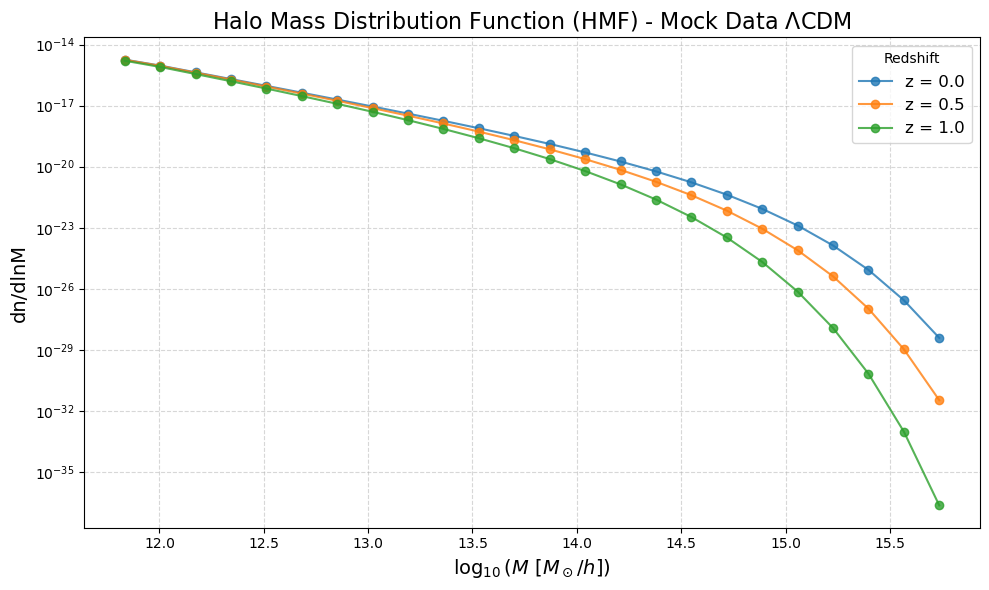

In [12]:
import matplotlib.pyplot as plt
Log10_Mass = np.log10(allM)

plt.figure(figsize=(10, 6))


for i, z_val in enumerate(zs):
    HMF_at_z = HMF_Tinker_Mock_Data[i, :]
    valid_mask = HMF_at_z > 0
    
    plt.plot(
        Log10_Mass[valid_mask], 
        HMF_at_z[valid_mask], 
        label=f'z = {z_val:.1f}', 
        linestyle='-', 
        marker='o',
        alpha=0.8
    )

plt.yscale('log')

plt.xlabel(r'$\log_{10}(M\ [M_\odot/h])$', fontsize=14)
plt.ylabel(r'dn/dlnM', fontsize=14)
plt.title(f'Halo Mass Distribution Function (HMF) - Mock Data $\\Lambda$CDM', fontsize=16)
plt.legend(title='Redshift', fontsize=12)
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

#### Add noise (Poisson Distributed)

In [ ]:
from scipy.stats import poisson

V_survey = 1e9

# Calculate mass ratio (should be consistent for log-spaced bins)
ratio = allM[1] / allM[0]

# Calculate bin edges (geometric means)
edges = np.zeros(allM.size + 1)
edges[1:-1] = np.sqrt(allM[:-1] * allM[1:])
edges[0] = allM[0] / np.sqrt(ratio)
edges[-1] = allM[-1] * np.sqrt(ratio)

# Calculate bin widths (Delta M)
widths = edges[1:] - edges[:-1]


N_i_true = HMF_Tinker_Mock_Data * V_survey * widths 

HMF_Poisson_Mock = np.zeros_like(HMF_Tinker_Mock_Data)

# apply noise and PD
for i_z in range(HMF_Tinker_Mock_Data.shape[0]):
    for i_M in range(HMF_Tinker_Mock_Data.shape[1]):
        
        N_true = N_i_true[i_z, i_M]
        
        N_obs = poisson.rvs(N_true) 

            
        
        n_mock = N_obs / (V_survey * widths[i_M])
        
        HMF_Poisson_Mock[i_z, i_M] = n_mock

In [14]:
# the number of halos observable in a volumn 1e9
print(N_i_true)

[[4.88426403e+05 3.67935156e+05 2.53971666e+05 1.74838975e+05
  1.19926335e+05 8.18606690e+04 5.55036602e+04 3.72921367e+04
  2.47506868e+04 1.61587001e+04 1.03194892e+04 6.39975003e+03
  3.81706880e+03 2.16195759e+03 1.14356192e+03 5.52579841e+02
  2.36913557e+02 8.67025924e+01 2.57202094e+01 5.76978147e+00
  8.91036650e-01 8.33480468e-02 3.96106316e-03 8.25097356e-05]
 [4.79642203e+05 3.58082248e+05 2.44164792e+05 1.65382730e+05
  1.11070716e+05 7.37913296e+04 4.83449431e+04 3.11124481e+04
  1.95695833e+04 1.19538361e+04 7.03284229e+03 3.94319377e+03
  2.07828144e+03 1.01152073e+03 4.44211622e+02 1.70745452e+02
  5.51894229e+01 1.42250855e+01 2.72383943e+00 3.52289187e-01
  2.70565584e-02 1.03522232e-03 1.55017646e-05 7.15678156e-08]
 [4.31704827e+05 3.15097544e+05 2.08970762e+05 1.36815740e+05
  8.81572787e+04 5.56923580e+04 3.43242810e+04 2.05118799e+04
  1.17934698e+04 6.46015439e+03 3.32949072e+03 1.58894476e+03
  6.87887338e+02 2.63076947e+02 8.58687041e+01 2.28662114e+01
  4.68

In [15]:
N_min = 10 
Mask = N_i_true >= N_min 

print("Mask (True = Bin is used, False = Bin is removed):\n", Mask)

widths_expanded = np.tile(widths, (HMF_Tinker_Mock_Data.shape[0], 1))

# C_ii = N_true / (V * dM)^2
C_ii_2D = N_i_true / (V_survey * widths_expanded)**2

# transform matrix 3x24 (C_ii_2D) to a vector 1D (dimension 72)
# The bins have the order: (z0, M1...M24), (z0.5, M1...M24), (z1.0, M1...M24)
C_ii_vector = C_ii_2D.flatten() 
C_ii_masked_vector = C_ii_vector[Mask.flatten()]

#Create a Covariance Matrix(C)
num_masked_bins = C_ii_masked_vector.size
Covariance_Matrix_C = np.diag(C_ii_masked_vector)

print(f"\nInitial number of bins (3x24): 72")
print(f"Number of bins retained (after Mask): {num_masked_bins}")
print(f"Covariance Matrix Dimensions C: {Covariance_Matrix_C.shape}")
print("\nDiagonal elements C_ii:")
print(Covariance_Matrix_C.diagonal()[:5])
print("...")
print(Covariance_Matrix_C.diagonal()[-5:])

Mask (True = Bin is used, False = Bin is removed):
 [[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True False False False False False]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True False False False False False False]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True False False False False False False False False]]

Initial number of bins (3x24): 72
Number of bins retained (after Mask): 53
Covariance Matrix Dimensions C: (53, 53)

Diagonal elements C_ii:
[6.79724408e-36 2.34371843e-36 7.40492198e-37 2.33332247e-37
 7.32574357e-38]
...
[4.08556564e-42 8.09582266e-43 1.41718825e-43 2.11729358e-44
 2.58071935e-45]


In [16]:

n_mock_vector = HMF_Poisson_Mock.flatten()

n_mock_masked = n_mock_vector[Mask.flatten()]

print(f"Target Data Vector Size (n_mock): {n_mock_masked.shape}")

Target Data Vector Size (n_mock): (53,)


In [17]:


# Calculate mass ratio (be consistent for log-spaced bins)
ratio = allM[1] / allM[0]

# Calculate bin edges (geometric means)
edges = np.zeros(allM.size + 1)
edges[1:-1] = np.sqrt(allM[:-1] * allM[1:])
edges[0] = allM[0] / np.sqrt(ratio)
edges[-1] = allM[-1] * np.sqrt(ratio)

# Calculate bin widths (Delta M)
widths = edges[1:] - edges[:-1]

print(widths)


[2.68060692e+11 3.96216836e+11 5.85642236e+11 8.65628893e+11
 1.27947388e+12 1.89117207e+12 2.79531261e+12 4.13171319e+12
 6.10702901e+12 9.02670706e+12 1.33422420e+13 1.97209714e+13
 2.91493023e+13 4.30851516e+13 6.36834986e+13 9.41297096e+13
 1.39131761e+14 2.05648590e+14 3.03966282e+14 4.49288165e+14
 6.64086249e+14 9.81576434e+14 1.45085370e+15 2.14448503e+15]


##### Compute Inverse Matrix, log_det_C 

In [18]:
C_inverse = np.linalg.inv(Covariance_Matrix_C)
sign, log_det_C = np.linalg.slogdet(Covariance_Matrix_C)

print(f"The log(det(C))'s value: {log_det_C}")
print(f"C_inverse dimension : {C_inverse.shape}")


The log(det(C))'s value: -4848.986299239308
C_inverse dimension : (53, 53)


#### Integrate MCMC 

In [19]:
model = keras.models.load_model("emulator_sigma_As_fixed.keras")

##### Create a log_prior

In [20]:
def log_prior(params_trial):
    Omh2, Ocmh2, H0, ns = params_trial
    
    if not (0.02 < Omh2 < 0.03): return -np.inf
    if not (0.1 < Ocmh2 < 0.15): return -np.inf
    if not (60.0 < H0 < 80.0): return -np.inf
    if not (0.9 < ns < 1.0): return -np.inf
        
    return 0.0 

##### Use "emulator" to compute the number halo model has mask applied

In [21]:
def get_n_emu_masked(Omb_h2, Omc_h2, H0, ns, As_mock, Z_target, Mask):
    
    w0_fixed = -1.0
    wa_fixed = 0.0
    As_emu = 2e-9
    
    n_emu_full = []
    
    for z in Z_target:
        params_test = np.array([[w0_fixed, wa_fixed, Omc_h2, ns, H0, Omb_h2]])
        
        inpu1 = scaler_X1.transform(params_test)
        y_prime = model.predict(inpu1)
        sigma_base = scaler_Y1.inverse_transform(y_prime).flatten() 

        scaling_factor = np.sqrt(As_mock / As_emu)
        if z ==0: 
            sigma_final = sigma_base * scaling_factor
        else : 
            Omega_m0 = (Omb_h2 + Omc_h2) / ((H0/100)**2) 
            D_z = growth_factor(z=z, Omega_m0=Omega_m0, w=w0_fixed, wa = wa_fixed)
            sigma_final = sigma_base * scaling_factor * D_z

        pars = camb.CAMBparams()
        pars.set_cosmology(H0=H0, ombh2=Omb_h2, omch2=Omc_h2, mnu=0, omk=0, tau=0.0561)
        pars.InitPower.set_params(As=As_emu, ns=ns)
        pars.set_dark_energy(w=-1, wa=0.0, dark_energy_model='ppf')
        
        # Compute HMF (n_emu) from Sigma_final
        n_emu_at_z = massfunction_Tinker_M500C(allM, z, sigma_final, pars)
        
        n_emu_full.append(n_emu_at_z)
        
    n_emu_full_vector = np.array(n_emu_full).flatten()
    n_emu_masked = n_emu_full_vector[Mask.flatten()]
    
    return n_emu_masked



##### Compute "Log-likelihood" 
$$
\ln \mathcal{L}(\theta) = -\frac{1}{2} \left[ \left( \mathbf{n}_{\text{mock}} - \mathbf{n}_{\text{emu}}(\theta) \right)^T \mathbf{C}^{-1} \left( \mathbf{n}_{\text{mock}} - \mathbf{n}_{\text{emu}}(\theta) \right) + \ln(\det(\mathbf{C})) \right]
$$


In [22]:
def log_likelihood(params_trial_4d, n_mock_masked, C_inverse, log_det_C, As_mock, Z_target, Mask):
    n_emu_masked = get_n_emu_masked(
        params_trial_4d[0],  # Omb_h2
        params_trial_4d[1],  # Omc_h2
        params_trial_4d[2],  # H0
        params_trial_4d[3],  # ns
        As_mock, Z_target, Mask
    )
    
    delta_n = n_mock_masked - n_emu_masked
    chi2_term = np.dot(delta_n, C_inverse).dot(delta_n)
    log_L = -0.5 * (chi2_term + log_det_C)
    
    return log_L

##### Log-Probability Function 

In [23]:

def full_log_probability(params_trial_4d, *args):
    lp = log_prior(params_trial_4d)
    if not np.isfinite(lp):
        return -np.inf 

    return lp + log_likelihood(params_trial_4d, *args)

##### Prepare to run "Sampler"

In [1]:
import pickle
import os

file_name = 'burnin_state.pkl'

with open(file_name, 'rb') as file:
            data = pickle.load(file)

In [2]:
print(data)

State([[2.22241739e-02 1.20680455e-01 6.80725647e+01 9.53795193e-01]
 [2.21905018e-02 1.21398491e-01 6.84520154e+01 9.45028362e-01]
 [2.22342158e-02 1.21729297e-01 6.84230945e+01 9.41750968e-01]
 [2.24070899e-02 1.20330894e-01 6.72228435e+01 9.62159168e-01]
 [2.21486454e-02 1.21532536e-01 6.83580495e+01 9.44462122e-01]
 [2.20385541e-02 1.21407778e-01 6.86119598e+01 9.43831488e-01]
 [2.20842158e-02 1.21171791e-01 6.85369614e+01 9.46825816e-01]
 [2.22036300e-02 1.21242181e-01 6.84779793e+01 9.46527770e-01]
 [2.22947814e-02 1.20548828e-01 6.73932916e+01 9.58933351e-01]
 [2.20104260e-02 1.21518957e-01 6.85495180e+01 9.42171242e-01]
 [2.21642496e-02 1.20409499e-01 6.75036988e+01 9.59977551e-01]
 [2.21804644e-02 1.20532097e-01 6.78292454e+01 9.57706091e-01]
 [2.22105442e-02 1.21327926e-01 6.84110531e+01 9.45903848e-01]
 [2.21965999e-02 1.21743300e-01 6.84492577e+01 9.42006764e-01]
 [2.20696567e-02 1.21521857e-01 6.85073941e+01 9.43036849e-01]
 [2.23009565e-02 1.20301367e-01 6.74772111e+01 9.

In [24]:
import emcee 
As_mock = 2.1e-9 
As_emu = 2.0e-9 
Z_target = np.array([0.0, 0.5, 1.0])

ndim = 4
nwalkers = 32 

target_params = np.array([0.02237, 0.12, 67.36, 0.9649])
pos = target_params + 1e-4 * np.random.randn(nwalkers, ndim)


args_for_sampler = (n_mock_masked, C_inverse, log_det_C, As_mock, Z_target, Mask)

sampler = emcee.EnsembleSampler(nwalkers, ndim, full_log_probability, args=args_for_sampler)



#### test parallelization 

##### Run emulator (Burn-in and Sampling)

##### Production Run 